# Исследование поведения пользователей мобильного приложения

## Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Задача - разобраться, как ведут себя пользователи вашего мобильного приложения. Для этого необходимо:

- Изучить воронку продаж;
- Исследовать результаты A/A/B-эксперимента. Эксперимент заключался в испытании нового шрифта приложения. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо определить, какой шрифт лучше.

## Описание данных

Каждая запись в логе — это действие пользователя, или событие. Файл `logs_exp.csv`:

- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Подготовка данных к анализу

Для работы с данными импортируем необходимые библиотеки:

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math as mth
from datetime import datetime, timedelta
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")

Перед началом исследования необходимо убедиться в корректности предоставленной информации. Изучим данные в таблице:

In [22]:
try:
    data = pd.read_csv('logs_exp.csv', sep='\t', decimal=',')
except:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t', decimal=',')
display(data.head())
data.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Данные изучены, обнаружены следующие замечания:

- Названия столбцов таблицы имеют разный регистр;
- Даты в таблице отображены в формате `unix time`.

In [23]:
# переименование столбцов
data = data.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'device_id_hash',
                           'EventTimestamp': 'event_timestamp', 'ExpId':'exp_id'})
# проверка на дубликаты
print('Количество дубликатов:', data.duplicated().sum())

# добавление столбеца даты и времени, а также отдельного столбца дат
data['time'] = pd.to_datetime(data['event_timestamp'], unit='s') 
data['date'] = data['time'].dt.round('D')
data.head()

Количество дубликатов: 413


,event_name,device_id_hash,event_timestamp,exp_id,time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [24]:
# удаление дубликатов
data = data.drop_duplicates().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   time             243713 non-null  datetime64[ns]
 5   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


Проверим, есть ли в таблице пользователи, которые одновременно вошли в разные группы:

In [25]:
# Пользователи, которые одновременно вошли в разные группы 
group_duplicate = data.groupby('device_id_hash', as_index=False).agg({'exp_id':'nunique'}).query('exp_id>1')['device_id_hash']
print('Количество пользователей, которые одновременно вошли в разные группы:', group_duplicate.count())

Количество пользователей, которые одновременно вошли в разные группы: 0


**Выводы:**
- Названия столбцов приведены к единому виду;
- Время события преобразовано к формату `datetime`;
- Удалены дубликаты;
- Данные проверены на пересекающихся пользователей, такие пользователи отсутствуют.

## Анализ данных

### Изучение и проверка данных

Ответим на следующие вопросы:

- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?

In [26]:
print('Количество событий в логе:', data['event_name'].count())
print('Количество пользователей в логе:', len(data['device_id_hash'].unique()))
event = data.groupby('device_id_hash', as_index=False).agg({'event_name':'count'})
print('Среднее количество событий на пользователя:', round(event['event_name'].mean()))

Количество событий в логе: 243713
Количество пользователей в логе: 7551
Среднее количество событий на пользователя: 32


Найдем максимальную и минимальную дату. После построим гистограмму по дате и времени. 

In [27]:
print('Минимальная дата:', data['date'].min())
print('Максимальная дата:', data['date'].max())

Минимальная дата: 2019-07-25 00:00:00
Максимальная дата: 2019-08-08 00:00:00


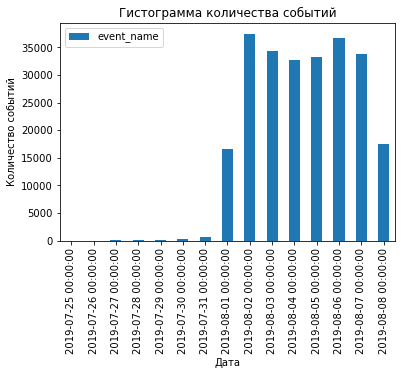

In [28]:
plot_date = data.pivot_table(index='date', values='event_name', aggfunc='count').plot(kind='bar') 
plt.title('Гистограмма количества событий')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

На гистограмме наблюдается яркий всплеск активности с 1 августа 2019 года. Событий до этой даты значительно меньше. Выясним, насколько много пользователей мы потеряем, если не будем учитывать события до указанной даты? Для этого вычислим количество пользователей, проявивших активность с 1 августа 2019 года и сравним их с общим количеством.

In [29]:
print('Количество пользователей в логе:', len(data['device_id_hash'].unique()))
print('Количество уникальных пользователей с 1 августа:', len(data.query('date>="2019-08-01"')['device_id_hash'].unique()))
print('Количество событий с 1 августа:', len(data.query('date>="2019-08-01"')))
print('Доля потерянных событий:', round((1-len(data.query('date>="2019-08-01"'))/data['event_name'].count())*100,2),'%')

Количество пользователей в логе: 7551
Количество уникальных пользователей с 1 августа: 7542
Количество событий с 1 августа: 242554
Доля потерянных событий: 0.48 %


Разница в 9 пользователей. Это 0.02% от общего количества. Практически все пользователи данного лога проявляли свою активность с 1 августа. Доля потерянных событий равна 0.48%. Потеря такого количества пользователей и событий допустима.

Возьмем за минимальную дату 1 августа 2019 года и отбросим старые данные. Проверим, остались ли пользователи из всех трёх экспериментальных групп.

In [30]:
df = data.query('date>="2019-08-01"')
group_users = pd.DataFrame(df['exp_id'].value_counts().reset_index())
group_users.columns = ['group', 'users']
group_users

,group,users
0,248,85167
1,246,79813
2,247,77574


### Изучение воронки событий

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [31]:
pd.DataFrame(df['event_name'].value_counts())

,event_name
MainScreenAppear,118320
OffersScreenAppear,46667
CartScreenAppear,42518
PaymentScreenSuccessful,34036
Tutorial,1013


Расшифровка событий:

- `Main Screen Appear` - появление главного экрана;          
- `Offers Screen Appear` - появление экрана предложений(товаров);          
- `Cart Screen Appear` - появление экрана корзины;           
- `Payment Screen Successful` - появление экрана успешной оплаты;     
- `Tutorial` - руководство. 

Посчитаем, сколько пользователей совершали каждое из этих событий, а также долю пользователей, которые хоть раз совершали событие.

In [32]:
table = (df.pivot_table(index='event_name', values='device_id_hash', aggfunc='nunique')
   .sort_values(by='device_id_hash', ascending=False))
table['share_users'] = round(table['device_id_hash']/len(df['device_id_hash'].unique())*100)
table

,device_id_hash,share_users
event_name,,
MainScreenAppear,7429,99.0
OffersScreenAppear,4603,61.0
CartScreenAppear,3741,50.0
PaymentScreenSuccessful,3542,47.0
Tutorial,845,11.0


Предположим, что события происходят в следующем порядке: MainScreenAppear >>> OffersScreenAppear >>> CartScreenAppear >>> PaymentScreenSuccessful (Главный экран >>> Экран предложений(товаров) >>> Экран корзины товаров >>> Экран успешной оплаты). Выбранные события связаны между собой последовательно. Уберем событие Tutorial (Руководство) из воронки событий, так как оно не является знаковым событием для достижения конечного результата. Также оно может находиться на любом этапе воронки.

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки.

In [33]:
funnel = (df.query('event_name!="Tutorial"')
            .pivot_table(index='event_name', values='device_id_hash', aggfunc='nunique')
            .sort_values(by='device_id_hash', ascending=False))

users = len(df['device_id_hash'].unique()) # количество уникальных пользователей
funnel['conversion'] = round((funnel['device_id_hash']/users)*100,1) # рассчет общей конверсии

# рассчет конверсии на шаге
funnel['conversion_step'] = ''
for i in range(4):
    funnel['conversion_step'][i] = round((funnel['device_id_hash'][i]/users)*100,1)
    users = funnel['device_id_hash'][i]
funnel

,device_id_hash,conversion,conversion_step
event_name,,,
MainScreenAppear,7429,98.5,98.5
OffersScreenAppear,4603,61.0,62.0
CartScreenAppear,3741,49.6,81.3
PaymentScreenSuccessful,3542,47.0,94.7


Всего уникальных пользователей в логе 7551. Возьмем их за 100%. Первый шаг прошли не все пользователи, причины могут быть разные, возможно пользователи довольствовались знакомством с приложением через "Руководство", либо попадали сразу на католог товаров (определенный продукт) через рекламу. Большего всего пользователей теряется на втором шаге, около 30% дальше главного экрана не уходят. С дальнейшими шагами ситуация выравнивается, почти половина пользователей доходит до оплаты товаров. 

### Изучение результатов эксперимента

Вычислим количество пользователей в каждой экспериментальной группе:

In [34]:
quantity_users = df.pivot_table(index='exp_id', values='device_id_hash', aggfunc='nunique').sort_values(by='exp_id')
quantity_users.loc['246_247']=quantity_users.loc[246,'device_id_hash'] + quantity_users.loc[247,'device_id_hash']
quantity_users

,device_id_hash
exp_id,
246,2485
247,2517
248,2540
246_247,5002


Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, есть ли статистическая разница конверсий между группами 246 и 247. Для начала построим воронку событий по группам.

In [35]:
funnel = (df.query('event_name!="Tutorial"')
            .pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique')
            .sort_values(by=246, ascending=False))
funnel['share_246,%'] = round((funnel[246]/users)*100,1)
funnel['share_247,%'] = round((funnel[247]/users)*100,1)
funnel['share_248,%'] = round((funnel[248]/users)*100,1)
funnel

exp_id,246,247,248,"share_246,%","share_247,%","share_248,%"
event_name,,,,,,
MainScreenAppear,2452,2479,2498,69.2,70.0,70.5
OffersScreenAppear,1543,1526,1534,43.6,43.1,43.3
CartScreenAppear,1267,1239,1235,35.8,35.0,34.9
PaymentScreenSuccessful,1200,1159,1183,33.9,32.7,33.4


**Определим нулевую и альтернативную гипотезы:**
- Нулевая: Конверсия групп 246 и 247 статистический различий не имеет;
- Альтернативная: Конверсия групп 246 и 247 имеет статистические различия;

Для удобства расчетов, напишем функцию проверки гипотезы:

In [36]:
def hypothesis(group_one, group_two, event): # функция проверки статистических гипотез
    
    alpha = .05 # критический уровень статистической значимости

    successes = np.array([funnel[group_one][event], funnel[group_two][event]])
    trials = np.array([quantity_users.loc[group_one,'device_id_hash'], 
                       quantity_users.loc[group_two,'device_id_hash']])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )
        
hypothesis(246, 247, 'PaymentScreenSuccessful')

p-значение:  0.11210845100173072
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Нулевая гипотеза о равенстве долей подтвердилась. Ожидаемый результат, с учетом разницы выборок менее 1%.

Проделаем то же самое для всех других событий контрольных групп:

In [37]:
hypothesis(246, 247, 'MainScreenAppear')
hypothesis(246, 247, 'OffersScreenAppear')
hypothesis(246, 247, 'CartScreenAppear')

p-значение:  0.5868776836512959
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.28743295207707353
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.21306131796590932
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для указанных событий гитотеза также подтвердилась. P-value выше критического уровня статистической значимости. Статистически значимое различие отсутствует. Мы можем быть уверены в точности проведенного тестирования.

Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Далее сравним результаты с объединённой контрольной группой. 

**Сравним группы 246 и 248. Определим гипотезы:**
- Нулевая: Конверсия групп 246 и 248 статистических различий не имеет;
- Альтернативная: Конверсия групп 246 и 248 имеет статистические различия.

In [38]:
hypothesis(246, 248, 'MainScreenAppear')
hypothesis(246, 248, 'OffersScreenAppear')
hypothesis(246, 248, 'CartScreenAppear')
hypothesis(246, 248, 'PaymentScreenSuccessful')

p-значение:  0.341286386031747
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.21653516964059394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.09381753258425052
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.22352231840506898
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Во всех гипотезах p-value выше критического уровня статистической значимости. Есть основания полагать, что конверсии групп 246 и 248 равны.

**Сравним группы 247 и 248. Определим гипотезы:**

- Нулевая: Конверсия групп 247 и 248 статистических различий не имеет;
- Альтернативная: Конверсия групп 247 и 248 имеет статистические различия.

In [39]:
hypothesis(247, 248, 'MainScreenAppear')
hypothesis(247, 248, 'OffersScreenAppear')
hypothesis(247, 248, 'CartScreenAppear')
hypothesis(247, 248, 'PaymentScreenSuccessful')

p-значение:  0.681958382603927
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.8648317820162639
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6678786497629776
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7065894728746211
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


И здесь во всех гипотезах p-value выше критического уровня статистической значимости. Гипотезы подтвердились.

**Сравним объединенные контрольные группы с 248. Определим гипотезы:**

- Нулевая: Конверсия контрольные групп и группы 248 статистических различий не имеет;
- Альтернативная: Конверсия контрольных групп и группы 248 имеет статистические различия.

In [40]:
funnel['246_247'] = funnel[246] + funnel[247] # объединенные контрольные группы
hypothesis('246_247', 248, 'MainScreenAppear')
hypothesis('246_247', 248, 'OffersScreenAppear')
hypothesis('246_247', 248, 'CartScreenAppear')
hypothesis('246_247', 248, 'PaymentScreenSuccessful')

p-значение:  0.42897263461182167
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.4182702544597574
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.22504740837954484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.629668311887492
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод**
- Количество пользователей в контрольных группах различается не более, чем на 1%, конверсия по группам не превышает 1% и не имеет статистической значимости. Исходя из этого, можно признать А/А тест успешным;
- Анализ А/В теста показал, что статистических различий в конверсии между группами отсутствует. Таким образом можно утверждать, что с высокой долей вероятности изменение шрифта в приложении не влияет на покупательскую способность пользователей.

При проверке статистических гипотез, уровень критической значимости был установлен на отметке 0.05. Всего было проведено 16 проверок статистических гипотез. Вероятность ошибки в случае проведения 12 тестов ((А1+А2)/В не учитываем, потому как А1/В, А2/В уже рассмотрели.), т.е. с ɑ=0,05: 1-(1-0.05)^12= 46%. Очень большой процент появления ошибки, проводить тестирование с таким значением нецелесообразно. Используя один из базовых методов поправки на множественную проверку гипотез - метод Бонферрони, скорректируем уровень значимости. В этом случае альфа будет равна 0.05/12 = 0.004. Тогда вероятность ошибки с ɑ=0,004 будет равна: 1-(1-0.004)^12= 5%. С учетом того, что p-значение не опускалось ниже 0.11, дополнительная проверка с уровнем значимости 0.004 не приведет к изменению результата.

## Общий вывод

Задача проекта — изучить поведение пользователей мобильного приложения, а также определить, как новые шрифты повлияют на их активность. В начале исследования была проведена предобработка данных, а именно:
- Названия столбцов приведены к единому виду;
- Время события преобразовано к формату `datetime`;
- Удалены дубликаты;
- Данные проверены на пересекающихся пользователей, такие пользователи отсутствуют.

Далее, для выполнения задачи были проверены и изучены данные датасета, составлена и изучена воронка продаж, в также исследованы результаты А/А и А/В эксперимента. В результате проведенного анализа установлено:
- Количество событий в логе 243713;
- Всего уникальных пользователей в логе 7551;
- Среднее количество событий на пользователя 32;
- Ввиду неравномерности распределения событий, начальная дата исследуемого периода была изменена с 25-07-2019 на 01-08-2019, в связи чем были потеряны данные о 9 пользователях, что составляет менее 1% от общего количества. Доля потерянных событий равна 0.48%. Потеря такого количества событий и пользователей допустима.
- Определён порядок событий:

      `Main Screen Appear` - появление главного экрана;          
      `Offers Screen Appear` - появление экрана предложений(товаров);          
      `Cart Screen Appear` - появление экрана корзины;           
      `Payment Screen Successful` - появление экрана успешной оплаты.
     
     
- Первый шаг прошли не все пользователи, причины могут быть разные, возможно клиенты довольствовались знакомством с приложением через "Руководство", либо попадали сразу на католог товаров (определенный продукт) через рекламу;
- Большего всего пользователей теряется на втором шаге, около 30% дальше главного экрана не уходят. С дальнейшими шагами ситуация выравнивается, почти половина пользователей доходит до оплаты товаров;
- Количество пользователей в контрольных группах различается не более, чем на 1%, конверсия по группам не превышает 1% и не имеет статистической значимости. Исходя из этого, можно признать А/А тест успешным;
- Анализ А/В теста показал, что статистических различий в конверсии между группами отсутствует. Таким образом можно утверждать, что с высокой долей вероятности изменение шрифта в приложении не влияет на покупательскую способность пользователей.